In [1]:
import json
import torchvision.transforms as transforms
from torchvision.datasets import OxfordIIITPet
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import torch
import os
import shutil
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
from transformers import T5Tokenizer, T5ForConditionalGeneration
from diffusers import StableDiffusionPipeline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

import random


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Acquisizione dati

In [3]:
# Definisci le trasformazioni da applicare alle immagini
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Ridimensiona le immagini
    transforms.ToTensor()           # Converti le immagini in tensori PyTorch
])

# Scarica il dataset e caricalo
dataset = OxfordIIITPet(root='/content/drive/MyDrive/Colab_Notebooks/data',
                        download=True, transform=transform)

# Verifica che il dataset sia stato scaricato correttamente
print(f"Numero di campioni nel dataset: {len(dataset)}")

# Recupera un esempio dal dataset
image, target = dataset[0]
print(f"Dimensioni dell'immagine: {image.size()}")
print(f"Etichetta: {target}")

Numero di campioni nel dataset: 3680
Dimensioni dell'immagine: torch.Size([3, 128, 128])
Etichetta: 0


# Image captioning per generare le descrizioni dalle immagini

In [4]:
# # Carica modello e processor
# processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
# model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").eval()

# # Percorso al dataset Oxford-IIIT Pet
# image_dir = "/content/drive/MyDrive/Colab_Notebooks/data/oxford-iiit-pet/images"

# dizionario_descrizioni = dict()

# # Loop su tutte le immagini
# for img_name in os.listdir(image_dir):
#     if img_name.endswith(".jpg"):
#         image = Image.open(os.path.join(image_dir, img_name)).convert("RGB")
#         inputs = processor(images=image, return_tensors="pt")
#         out = model.generate(**inputs)
#         caption = processor.decode(out[0], skip_special_tokens=True)
#         dizionario_descrizioni[img_name] = caption

#### i tempi di generazione delle descrizioni sono lunghi quindi si salvano le descrizioni in un json da importare per successive esecuzioni e commentiamo il codice

In [5]:
# with open("/content/drive/MyDrive/Colab_Notebooks/data/oxford-iiit-pet/descrizioni.json", "w", encoding="utf-8") as f:
#     json.dump(dizionario_descrizioni, f, ensure_ascii=False, indent=4)

# print(f"Dati salvati su drive")

In [6]:
# Carica le descrizioni da un file JSON in un dizionario
with open("/content/drive/MyDrive/Colab_Notebooks/data/oxford-iiit-pet/descrizioni.json", "r", encoding="utf-8") as f:
    dizionario_descrizioni = json.load(f)

## Generazione di varianti delle descrizione ottenute dalle immagini originali

In [7]:
# # Inizializza modello e tokenizer
# model = T5ForConditionalGeneration.from_pretrained("ramsrigouthamg/t5_paraphraser")
# tokenizer = T5Tokenizer.from_pretrained("ramsrigouthamg/t5_paraphraser")

# # Dizionario per salvare le varianti
# dizionario_varianti = {}

# k = 1

# # Loop su ogni immagine e caption
# for nome_img, caption in dizionario_descrizioni.items():
#     print(f"descrizione {str(k)} di {str(len(dizionario_descrizioni))}")
#     input_text = f"paraphrase: {caption}"
#     encoding = tokenizer.encode_plus(input_text, return_tensors="pt")

#     outputs = model.generate(
#         input_ids=encoding['input_ids'],
#         attention_mask=encoding['attention_mask'],
#         max_length=64,
#         num_return_sequences=3,
#         do_sample=True, # il parametro do_sample=True permette di generare sequenze più "creative"
#         temperature=1.5,
#         top_p=0.9
#     )

#     varianti = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]

#     # Salva nel nuovo dizionario tutte le varianti per ogni immagine
#     dizionario_varianti[nome_img] = {
#         "originale": caption,
#         "variante_1": varianti[0],
#         "variante_2": varianti[1],
#         "variante_3": varianti[2]
#     }

#     k = k + 1



#### anche in questo caso si salva tutto in un file json e si commenta il codice, dati i tempi molto lunghi

In [8]:
# # Salva tutto in un nuovo file JSON
# with open("/content/drive/MyDrive/Colab_Notebooks/data/oxford-iiit-pet/varianti.json", "w", encoding="utf-8") as f:
#     json.dump(dizionario_varianti, f, ensure_ascii=False, indent=4)

# print("Salvato dizionario con varianti in 'varianti.json'")

In [9]:
# Carica dizionario_varianti da file JSON
with open("/content/drive/MyDrive/Colab_Notebooks/data/oxford-iiit-pet/varianti.json", "r", encoding="utf-8") as f:
    dizionario_varianti = json.load(f)

## Modifica della razza nelle descrizioni generate

#### Le descrizioni parlano solo di "cane" o "gatto": modifichiamo il testo mettendo "a dog/cat of breed...." al posto del semplice "cat/dog". Specificando la razza nel testo proviamo a indirizzare il modello sulla generazione di quella specifica razza

In [10]:
dizionario_razze = {
    "Abyssinian": "cat",
    "Bengal": "cat",
    "Birman": "cat",
    "Bombay": "cat",
    "British Shorthair": "cat",
    "Egyptian Mau": "cat",
    "Maine Coon": "cat",
    "Persian": "cat",
    "Ragdoll": "cat",
    "Russian Blue": "cat",
    "Siamese": "cat",
    "Sphynx": "cat",
    "american bulldog": "dog",
    "american pit bull terrier": "dog",
    "basset hound": "dog",
    "beagle": "dog",
    "boxer": "dog",
    "chihuahua": "dog",
    "english cocker spaniel": "dog",
    "english setter": "dog",
    "german shorthaired": "dog",
    "golden retriever": "dog",
    "great pyrenees": "dog",
    "havanese": "dog",
    "husky": "dog",
    "japanese chin": "dog",
    "keeshond": "dog",
    "leonberger": "dog",
    "miniature pinscher": "dog",
    "newfoundland": "dog",
    "pomeranian": "dog",
    "labrador retriever": "dog",
    "malamute": "dog",
    "pug": "dog",
    "saint bernard": "dog",
    "samoyed": "dog",
    "scottish terrier": "dog",
    "shiba inu": "dog",
    "staffordshire bull terrier": "dog",
    "wheaten terrier": "dog",
    "yorkshire terrier": "dog"
    }

In [11]:
def normalize_name(name: str) -> str:
    """Minuscole + trattini bassi in spazi."""
    return name.lower().replace("_", " ")

In [12]:
# # Normalizza le chiavi del dizionario delle razze: minuscole + trattini bassi -> spazi
# normalized_dizionario_razze = {
#     k.lower().replace("_", " "): v for k, v in dizionario_razze.items()
# }

# # Elabora il file JSON
# for img_key, captions in dizionario_varianti.items():
#     # Estraggo la parte della razza: tutto prima di "_numero.jpg"
#     breed_name = "_".join(img_key.split("_")[:-1]).replace(".jpg", "")
#     breed_name_norm = normalize_name(breed_name)

#     # Controllo se la razza è nel dizionario
#     if breed_name_norm in normalized_dizionario_razze:
#         animal_type = normalized_dizionario_razze[breed_name_norm]  # "dog" o "cat"

#         # Sostituzione nei testi
#         for caption_key, text in captions.items():
#             # Solo se contiene "dog" o "cat"
#             if "dog" in text.lower() or "cat" in text.lower():
#                 if animal_type == "dog":
#                     text = re.sub(r"\bdog\b", f"dog of breed {breed_name_norm}", text, flags=re.IGNORECASE)
#                 elif animal_type == "cat":
#                     text = re.sub(r"\bcat\b", f"cat of breed {breed_name_norm}", text, flags=re.IGNORECASE)
#             captions[caption_key] = text
#
# # Salvataggio del nuovo JSON
# with open("/content/drive/MyDrive/Colab_Notebooks/data/oxford-iiit-pet/varianti_razze.json", "w", encoding="utf-8") as f:
#     json.dump(dizionario_varianti, f, ensure_ascii=False, indent=4)

In [13]:
with open("/content/drive/MyDrive/Colab_Notebooks/data/oxford-iiit-pet/varianti_razze.json", "r", encoding="utf-8") as f:
    dizionario_varianti = json.load(f)

## Generazione di immagini dalle descrizioni ottenute

#### i tempi di generazione sono molto lunghi, anche utilizzando la GPU T4. Per questo motivo selezioniamo 9 razze di cane casuali sulle quali costruiremo il nostro modello di riconoscimento

In [14]:
# # 1. Filtra solo le razze di cane
# razze_cani = [normalize_name(r) for r, specie in dizionario_razze.items() if specie == "dog"]

# # 2. Scegli casualmente 9 razze di cane
# random.seed(42)  # per riproducibilità
# razze_scelte = random.sample(razze_cani, 9)

# print("Razze selezionate:", razze_scelte)

# # 3. Crea un dizionario per ogni razza selezionata
# dizionari_per_razza = {}

# for nome_img, contenuto in dizionario_varianti.items():
#     # Estrai il nome della razza (tutto prima dell'ultimo underscore)
#     nome_razza_img = "_".join(nome_img.split("_")[:-1])
#     nome_razza_norm = normalize_name(nome_razza_img)

#     if nome_razza_norm in razze_scelte:
#         if nome_razza_norm not in dizionari_per_razza:
#             dizionari_per_razza[nome_razza_norm] = {}
#         dizionari_per_razza[nome_razza_norm][nome_img] = contenuto

# # salvataggio del dizionario diviso per razza con le sole razze selezionate.
# # Salva in JSON
# with open("/content/drive/MyDrive/Colab_Notebooks/data/oxford-iiit-pet/varianti_razze_selezionate_casualmente.json", "w", encoding="utf-8") as f:
#     json.dump(dizionari_per_razza, f, indent=4, ensure_ascii=False)

with open("/content/drive/MyDrive/Colab_Notebooks/data/oxford-iiit-pet/varianti_razze_selezionate_casualmente.json", "r", encoding="utf-8") as f:
    dizionari_per_razze_selezionate = json.load(f)


In [15]:
print(list(dizionari_per_razze_selezionate.keys()))

['beagle', 'newfoundland', 'wheaten terrier', 'american bulldog', 'samoyed', 'english setter', 'german shorthaired', 'boxer', 'shiba inu']


#### sempre per limiti di tempo, generiamo immagini solo per la descrizione originale e la variante 1. Facciamo quindi due sole generazioni e non 4.  Generiamo le immagini di una delle 10 razze selezionate per volta, per refreshare la sessione di colab e poter usare la GPU

In [16]:
razza_sessione = "shiba inu"
dizionario_sessione_corrente = dizionari_per_razze_selezionate[razza_sessione]
print(list(dizionario_sessione_corrente.keys())[1:4])
print(str(len(dizionario_sessione_corrente.keys())) + " immagini per questa razza")

['shiba_inu_126.jpg', 'shiba_inu_176.jpg', 'shiba_inu_45.jpg']
200 immagini per questa razza


In [17]:
# # Inizializza Stable Diffusion
# pipe = StableDiffusionPipeline.from_pretrained(
#     "runwayml/stable-diffusion-v1-5",
#     torch_dtype=torch.float16,
# ).to("cuda" if torch.cuda.is_available() else "cpu")

# pipe.enable_attention_slicing()

# # Directory base per immagini sintetiche
# output_root = "/content/drive/MyDrive/Colab_Notebooks/data/oxford-iiit-pet/immagini_sintetiche"
# os.makedirs(output_root, exist_ok=True)

# # Numero di immagini per caption, rimaniamo con 1 immagine per ogni descrizione (comprese quelle sintetiche)
# num_per_caption = 1

# k = 1

# # Generazione
# for nome_img, descrizioni in dizionario_sessione_corrente.items():
#   print(f"generazione immagini {str(k)} di {str(len(dizionario_sessione_corrente))}")

#   # Estrai nome classe (prima parte del nome)
#   nome_classe = nome_img.split("_")[0]

#   # Crea cartella per la classe
#   class_dir = os.path.join(output_root, nome_classe)
#   os.makedirs(class_dir, exist_ok=True)

#   for chiave, caption in descrizioni.items():
#     if chiave not in ["originale", "variante_1"]:
#         continue  # Salta le altre varianti

#     for i in range(num_per_caption):
#         # Genera immagine
#         image = pipe(prompt=caption, guidance_scale=7.5).images[0]

#         # Salva immagine
#         suffix = f"{chiave}_{i+1}" if num_per_caption > 1 else chiave
#         filename = f"{nome_img.replace('.jpg','')}_{suffix}.png"
#         image.save(os.path.join(class_dir, filename))

#         print(f"[✓] Salvata: {os.path.join(nome_classe, filename)}")
#   k = k + 1


## Creazione delle cartelle per addestramento modelli di riconoscimento

#### Creiamo una cartella con le immagini originali per ogni classe. Ogni immagine viene inoltre aggiunta anche alla cartella delle immagini sintetiche. Anche questa operazione viene commentata dopo l'esecuzione perchè non è velocissima

In [18]:
# Percorsi
# cartella_sintetiche = "/content/drive/MyDrive/Colab_Notebooks/data/oxford-iiit-pet/immagini_sintetiche"
# cartella_images = "/content/drive/MyDrive/Colab_Notebooks/data/oxford-iiit-pet/images"
# cartella_originali = "/content/drive/MyDrive/Colab_Notebooks/data/oxford-iiit-pet/immagini_originali"

# # Crea cartella immagini_originali con la stessa struttura di immagini_sintetiche
# os.makedirs(cartella_originali, exist_ok=True)

# # Leggi sottocartelle da immagini_sintetiche e ricreale in immagini_originali
# for nome_classe in os.listdir(cartella_sintetiche):
#     path_sintetiche = os.path.join(cartella_sintetiche, nome_classe)
#     if os.path.isdir(path_sintetiche):
#         os.makedirs(os.path.join(cartella_originali, nome_classe), exist_ok=True)

# def estrai_classe_da_filename(file_name: str) -> str:
#     """
#     Restituisce tutto ciò che c'è prima dell'ULTIMO underscore,
#     assumendo che dopo l'ultimo underscore ci sia il numero progressivo.
#     Esempi:
#       'golden_retriever_12.jpg' -> 'golden_retriever'
#       'persian_3.jpg'           -> 'persian'
#     """
#     stem, _ = os.path.splitext(file_name)
#     if "_" not in stem:
#         return stem  # fallback: nessun underscore
#     classe, ultimo = stem.rsplit("_", 1)
#     # se vuoi essere più rigoroso, considera valido solo se 'ultimo' è un numero
#     if ultimo.isdigit():
#         return classe
#     # se non è un numero, fallback: prendi comunque tutto prima dell'ultimo underscore
#     return classe

# # estensioni accettate
# ESTENSIONI = (".jpg", ".jpeg", ".png")

# copiati = 0
# skippati = 0

# for file_name in os.listdir(cartella_images):
#   if not file_name.lower().endswith(ESTENSIONI):
#       continue

#   src_path = os.path.join(cartella_images, file_name)
#   if not os.path.isfile(src_path):
#       continue

#   # estrai la classe come "tutto prima dell'ultimo underscore"
#   nome_classe = estrai_classe_da_filename(file_name)
#   if nome_classe in os.listdir(cartella_sintetiche):

#     # prepara le sottocartelle di destinazione (creale se mancanti)
#     dst_sintetiche_dir = os.path.join(cartella_sintetiche, nome_classe)
#     dst_originali_dir = os.path.join(cartella_originali, nome_classe)
#     os.makedirs(dst_sintetiche_dir, exist_ok=True)
#     os.makedirs(dst_originali_dir, exist_ok=True)

#     # destinazioni complete
#     dst_sintetiche = os.path.join(dst_sintetiche_dir, file_name)
#     dst_originali = os.path.join(dst_originali_dir, file_name)

#     try:
#         shutil.copy2(src_path, dst_sintetiche)
#         shutil.copy2(src_path, dst_originali)
#         copiati += 1
#     except Exception as e:
#         print(f"Skip '{file_name}' per errore di copia: {e}")
#         skippati += 1

# print(f"Completato. Copiati: {copiati}, Skippati: {skippati}")



## Addestramento modello con stessa architettura sui due dataset

Abbiamo due cartelle distinte, una con le sole immagini originale e una con le immagini originali + le immagini sintetiche. In queste cartelle le immagini sono divise in sottocartelle con il nome della classe

In [21]:
def addestra_modello_su_dataset(cartella_dataset, img_size=(224, 224), batch_size=32, epochs=1000, test_split=0.2):
    """
    Addestra un modello di classificazione immagini multiclasse usando EfficientNetB0 con transfer learning.
    Restituisce anche le metriche di performance e la confusion matrix.

    Args:
        cartella_dataset (str): Percorso alla cartella contenente le immagini suddivise in sottocartelle per classe.
        img_size (tuple): Dimensione a cui ridimensionare le immagini (larghezza, altezza).
        batch_size (int): Numero di immagini per batch.
        epochs (int): Numero massimo di epoche di addestramento.
        test_split (float): Percentuale di immagini da usare come validation set.

    Returns:
        dict: Dizionario contenente le metriche di performance (accuracy, precision, recall, F1-score).
    """

    # -----------------------------
    # Generatori di immagini
    # -----------------------------
    # Data augmentation + split
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=test_split
    )

    # Training generator
    train_gen = train_datagen.flow_from_directory(
        cartella_dataset,
        target_size=img_size,
        batch_size=batch_size,
        class_mode="categorical",
        subset="training",
        shuffle=True,
        seed=123
    )

    # Validation generator
    val_gen = train_datagen.flow_from_directory(
        cartella_dataset,
        target_size=img_size,
        batch_size=batch_size,
        class_mode="categorical",
        subset="validation",
        shuffle=False,
        seed=123
    )



    # datagen_train = ImageDataGenerator(
    #     rescale=1./255,
    #     validation_split=test_split,
    #     horizontal_flip=True,
    #     rotation_range=25,
    #     zoom_range=0.2,
    # )

    # datagen_val = ImageDataGenerator(
    #     rescale=1./255,
    #     validation_split=test_split
    # )

    # train_gen = datagen_train.flow_from_directory(
    #     cartella_dataset,
    #     target_size=img_size,
    #     batch_size=batch_size,
    #     class_mode='categorical',
    #     subset='training'
    # )

    # val_gen = datagen_val.flow_from_directory(
    #     cartella_dataset,
    #     target_size=img_size,
    #     batch_size=batch_size,
    #     class_mode='categorical',
    #     subset='validation',
    #     shuffle=False
    # )

    num_classi = len(train_gen.class_indices)
    class_names = list(val_gen.class_indices.keys())

    # -----------------------------
    # Modello EfficientNetB0
    # -----------------------------
    # Creo il modello direttamente sulla GPU 0
    with tf.device("/GPU:0"):
      base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

    # Congela i layer iniziali, sblocca gli ultimi
    for layer in base_model.layers[:-20]:
        layer.trainable = False
    for layer in base_model.layers[-20:]:
        layer.trainable = True

    # Testa personalizzata
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.4)(x)  # Dropout per ridurre overfitting
    x = Dense(512, activation='relu')(x)
    output = Dense(num_classi, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)

    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # -----------------------------
    # Callback: EarlyStopping + ReduceLROnPlateau
    # -----------------------------
    early_stop = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)
    lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5)

    # -----------------------------
    # Training
    # -----------------------------
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=[early_stop, lr_scheduler],
        verbose=1
    )

    # -----------------------------
    # Valutazione
    # -----------------------------
    y_true = val_gen.classes
    y_pred = np.argmax(model.predict(val_gen), axis=1)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # -----------------------------
    # Confusion Matrix
    # -----------------------------
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }

#### Salviamo le statistiche dei modelli e le ricarichiamo, visti i tempi lunghi anche in questo caso

#### Modello addestrato su immagini originali

Found 1440 images belonging to 9 classes.
Found 360 images belonging to 9 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 198s 3s/step - accuracy: 0.1049 - loss: 2.2293 - val_accuracy: 0.1111 - val_loss: 2.2110 - learning_rate: 1.0000e-04
Epoch 2/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 265ms/step - accuracy: 0.1270 - loss: 2.2150 - val_accuracy: 0.1111 - val_loss: 2.2086 - learning_rate: 1.0000e-04
Epoch 3/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 14s 320ms/step - accuracy: 0.1097 - loss: 2.2185 - val_accuracy: 0.1111 - val_loss: 2.2055 - learning_rate: 1.0000e-04
Epoch 4/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 264ms/step - accuracy: 0.1297 - loss: 2.1992 - val_accuracy: 0.1111 - val_loss: 2.2028 - learning_rate: 1.0000e-04
Epoch 5/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 259ms/step - accuracy: 0.1294 - loss: 2.2008 - val_accuracy: 0.1111 - val_loss: 2.2039 - learning_rate: 1.0000e-04
Epoch 6/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 257ms/step - accuracy: 0.1329 - loss: 2.2063 - val_accuracy: 0.1111 - val_loss: 2.2061 - learning_rate: 1.0000e-04
Epoch 7/1000
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 272m

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

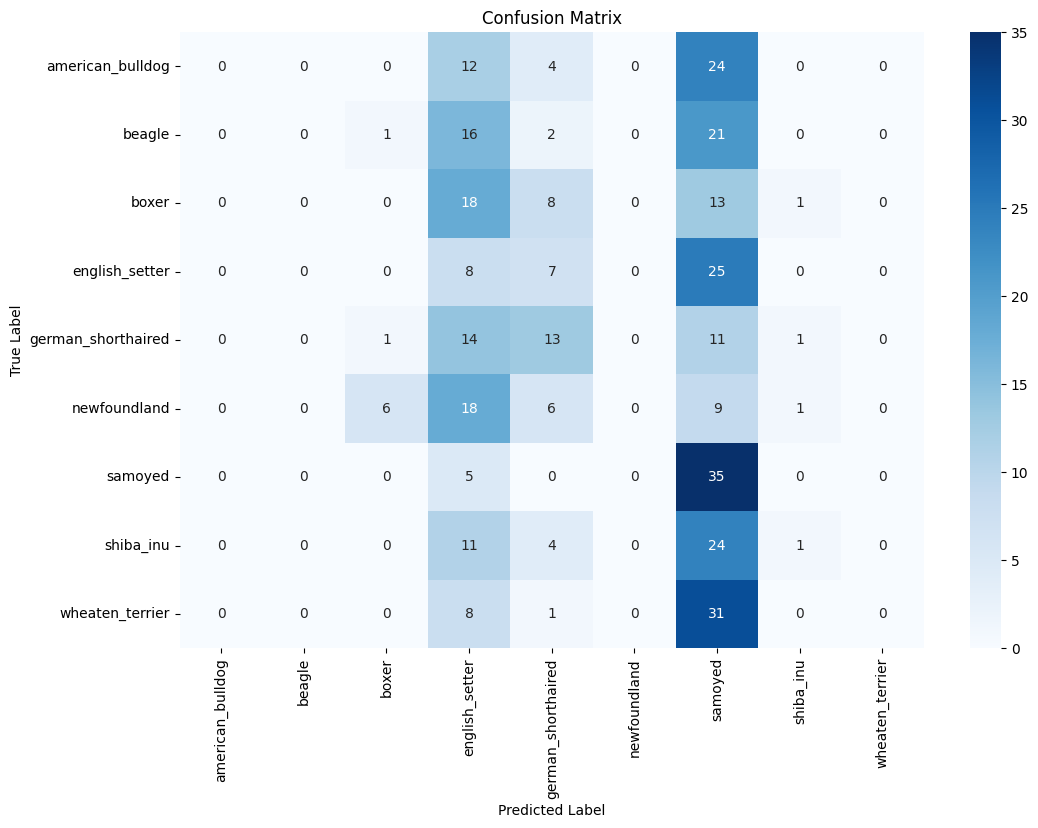

In [22]:
# metrics_dataset1 = addestra_modello_su_dataset("/content/drive/MyDrive/Colab_Notebooks/data/oxford-iiit-pet/immagini_originali")

# with open("/content/drive/MyDrive/Colab_Notebooks/data/oxford-iiit-pet/metriche_solo_immagini_originali.json", "w", encoding="utf-8") as f:
#      json.dump(metrics_dataset1, f, ensure_ascii=False, indent=4)

with open("/content/drive/MyDrive/Colab_Notebooks/data/oxford-iiit-pet/metriche_solo_immagini_originali.json", "r", encoding="utf-8") as f:
    metrics_dataset1 = json.load(f)



In [23]:
print(metrics_dataset1)


{'accuracy': 0.15833333333333333, 'precision': 0.08810703465280322, 'recall': 0.15833333333333333, 'f1_score': 0.0842703055124161}


#### Modello addestrato su immagini originali + immagini sintetiche

Found 4108 images belonging to 9 classes.
Found 1027 images belonging to 9 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 3389s 26s/step - accuracy: 0.1162 - loss: 2.2115 - val_accuracy: 0.1168 - val_loss: 2.2040 - learning_rate: 1.0000e-04
Epoch 2/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 69s 534ms/step - accuracy: 0.1342 - loss: 2.1963 - val_accuracy: 0.1168 - val_loss: 2.2024 - learning_rate: 1.0000e-04
Epoch 3/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 65s 504ms/step - accuracy: 0.1320 - loss: 2.1923 - val_accuracy: 0.1315 - val_loss: 2.1894 - learning_rate: 1.0000e-04
Epoch 4/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 64s 494ms/step - accuracy: 0.1313 - loss: 2.1863 - val_accuracy: 0.1276 - val_loss: 2.1662 - learning_rate: 1.0000e-04
Epoch 5/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 62s 482ms/step - accuracy: 0.1456 - loss: 2.1725 - val_accuracy: 0.1412 - val_loss: 2.1794 - learning_rate: 1.0000e-04
Epoch 6/1000
129/129 ━━━━━━━━━━━━━━━━━━━━ 82s 483ms/step - accuracy: 0.1442 - loss: 2.1709 - val_accuracy: 0.1538 - val_loss: 2.1517 - learning_rate: 1.0000e-04
Epoch 7/1000
129/129 ━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

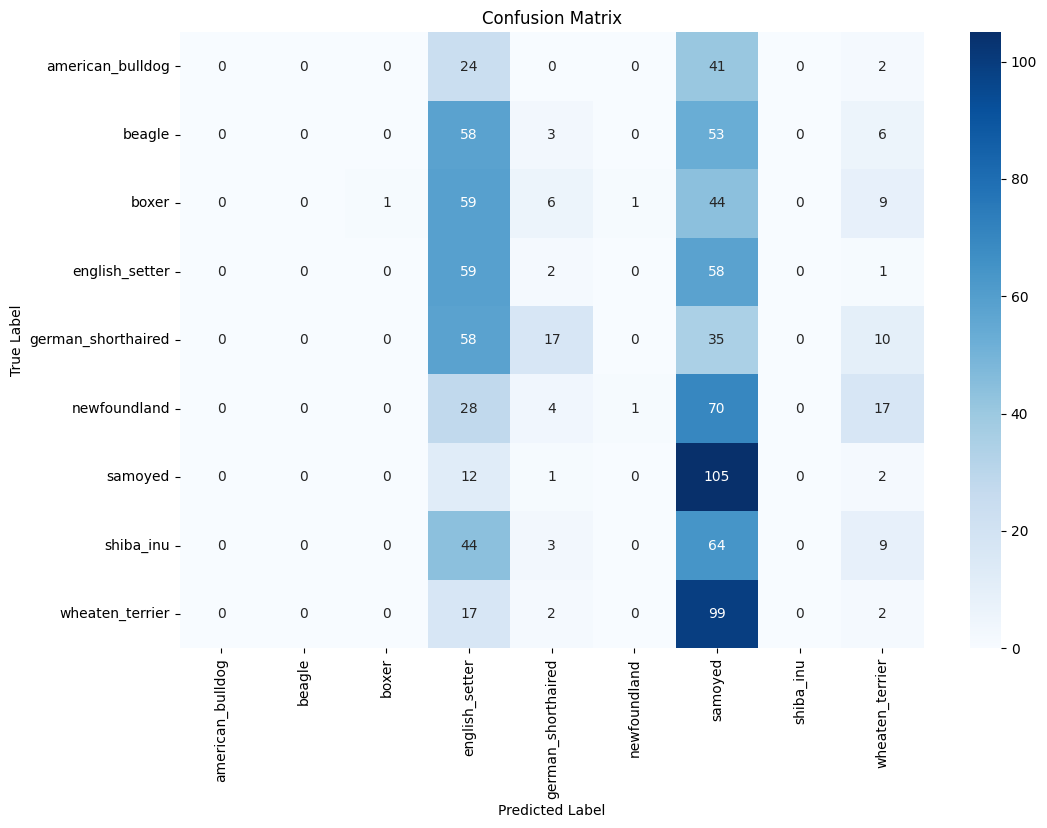

In [24]:
# metrics_dataset2 = addestra_modello_su_dataset("/content/drive/MyDrive/Colab_Notebooks/data/oxford-iiit-pet/immagini_sintetiche")

# with open("/content/drive/MyDrive/Colab_Notebooks/data/oxford-iiit-pet/metriche_con immagini sintetiche.json", "w", encoding="utf-8") as f:
#      json.dump(metrics_dataset2, f, ensure_ascii=False, indent=4)

with open("/content/drive/MyDrive/Colab_Notebooks/data/oxford-iiit-pet/metriche_con immagini sintetiche.json", "r", encoding="utf-8") as f:
    metrics_dataset2 = json.load(f)


In [25]:
print(metrics_dataset2)


{'accuracy': 0.1801363193768257, 'precision': 0.27233466651099975, 'recall': 0.1801363193768257, 'f1_score': 0.09601405147057758}


## Analisi delle performance

Purtroppo i modelli di riconoscimento non riescono a distinguere bene le razze di cane utilizzate in questa analisi; nonostante questo, un miglioramento si vede, quindi probabilmente l'utilizzo delle immagini sintetiche sembra una buona strada, sicuramente anche per l'aumento della numerosità del dataset. C'è da dire che non sempre le descrizioni hanno portato alla creazione di immagini accurate, in molti casi il modello ha creato semplicemente l'immagine di un cane ignorando l'indicazione della razza.

Quindi sicuramente servirebbe un addestramento migliore dei modelli di riconoscimento, magari senza il freeze, avendo a disposizione maggiori risorse hardware. La generazione delle immagini sintetiche sembra un buon mezzo per migliorare le performance, ma servirebbe un modello più accurato, non tanto per il tipo di immagine generata ma quando per il riconoscimento della razza indicata nel prompt descrittivo